# Demosaicizzazione lineare sul Pattern di Bayer

## Kodak Dataset

Le immagini utilizzate sono state prese dal dataset di immagini RAW Kodak (.PCD):

> https://www.math.purdue.edu/~lucier/PHOTO_CD/

In [1]:
# Loading Kodak Image Dataset

import numpy as np
import pandas
import imageio.v2 as imageio
import matplotlib.pyplot as plt

data_images = pandas.read_csv('dataset.csv')
image_list = []

for i in range(data_images.shape[0]):
    pcd_images = imageio.imread(data_images.loc[i, 'image_path'], format = 'PCD')
    image_list.append(pcd_images)

# Errori nella lettura: FILE [3], [8], [9], [16], [17], [18]

In [2]:
# Algoritmo di demosaicizzazione 
# lineare per pattern RGGB

def combine_channels(ch1, ch2, ch3):
    return np.dstack((ch1, ch2, ch3))

def demosaic_simple_naive_rgb(img):
    
    s = img.shape
    img = img.astype(np.uint16)
    red = np.zeros_like(img)
    blue = np.zeros_like(img)
    green = np.zeros_like(img)

    for i in range(s[0]): # rows
        for j in range(s[1]): # columns
            im1, ip1, jm1, jp1 = (max(0, i - 1), min(i + 1, s[0] - 1), max(0, j - 1), min(j + 1, s[1] - 1)) # per i pixel al bordo
            if (i % 2 == 0 and j % 2 == 0): # canale del rosso
                
                red[i, j] = img[i, j]
                blue[i, j] = (img[im1, jm1] + img[ip1, jm1] + img[ip1, jp1] + img[im1, jp1]) // 4 # media dei valori dei punti vicini
                green[i, j] = (img[im1, j] + img[ip1, j] + img[i, jm1] + img[i, jp1]) // 4
                
            elif (i % 2 == 1 and j % 2 == 1): # canale del blu
                
                blue[i, j] = img[i, j]
                red[i, j] = (img[im1, jm1] + img[ip1, jm1] + img[ip1, jp1] + img[im1, jp1]) // 4
                green[i, j] = (img[im1, j] + img[ip1, j] + img[i, jm1] + img[i, jp1]) // 4
                
            else: # canale del verde
                green[i, j] = img[i, j]
                if (i % 2 == 0): 
                    
                    red[i, j] = (img[i, jm1] + img[i, jp1]) // 2
                    blue[i, j] = (img[im1, j] + img[ip1, j]) // 2
                    
                else:
                    
                    blue[i, j] = (img[i, jm1] + img[i, jp1]) // 2
                    red[i, j] = (img[im1, j] + img[ip1, j]) // 2

    return (red, green, blue)

def demosaic_simple_naive(img):
    
    red,green,blue = demosaic_simple_naive_rgb(img)
    return combine_channels(red,green,blue).astype(np.uint8)

In [3]:
import numpy as np
from scipy.interpolate import griddata

def linear_interpolation(A, m, n):

    grid_x, grid_y = np.meshgrid(np.linspace(0, m-1, m), np.linspace(0, n-1, n), indexing = 'ij')

    n, m = A.shape
    A = A.flatten()

    nan_indices = np.isnan(A) 
    known_indices = ~nan_indices
    known_list = np.flatnonzero(known_indices)

    kr, kc = np.unravel_index(known_list, (n, m))

    points = np.zeros([len(kr),2])
    points[:,0] = kr
    points[:,1] = kc 

    A = np.reshape(A, [n,m])
    values = A[kr,kc] 

    return griddata(points, values, (grid_x, grid_y), fill_value=1, method = 'linear') 

In [4]:
import numpy as np
from scipy.interpolate import griddata

def nearest_interpolation(A, m, n):
    
    grid_x, grid_y = np.meshgrid(np.linspace(0, m-1, m), np.linspace(0, n-1, n), indexing = 'ij')

    n, m = A.shape
    A = A.flatten()

    nan_indices = np.isnan(A) 
    known_indices = ~nan_indices
    known_list = np.flatnonzero(known_indices)

    kr, kc = np.unravel_index(known_list, (n, m))

    points = np.zeros([len(kr),2])
    points[:,0] = kr
    points[:,1] = kc 

    A = np.reshape(A, [n,m])
    values = A[kr,kc] 

    return griddata(points, values, (grid_x, grid_y), method = 'nearest') 

In [5]:
import numpy as np
from scipy.interpolate import griddata

def cubic_interpolation(A, m, n):
    
    grid_x, grid_y = np.meshgrid(np.linspace(0, m-1, m), np.linspace(0, n-1, n), indexing = 'ij')

    n, m = A.shape
    A = A.flatten()

    nan_indices = np.isnan(A) 
    known_indices = ~nan_indices
    known_list = np.flatnonzero(known_indices)

    kr, kc = np.unravel_index(known_list, (n, m))

    points = np.zeros([len(kr),2])
    points[:,0] = kr
    points[:,1] = kc 

    A = np.reshape(A, [n,m])
    values = A[kr,kc] 

    return griddata(points, values, (grid_x, grid_y), fill_value=0, method = 'cubic') 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr


def demosaicing_bayer(image, Red_Inpaint, Green_Inpaint, Blue_Inpaint):
    
    bayer = np.empty((image[:,:,0].shape), np.uint8)
    
    Glinear = image.copy()
    Gnearest = image.copy()
    Gcubic = image.copy()
    
    # Immagine Grigia
    bayer[0::2, 0::2] = Red_Inpaint[0::2, 0::2]   # top left 
    bayer[0::2, 1::2] = Green_Inpaint[0::2, 1::2] # top right
    bayer[1::2, 0::2] = Green_Inpaint[1::2, 0::2] # bottom left
    bayer[1::2, 1::2] = Blue_Inpaint[1::2, 1::2]  # bottom right
    
    tic = time.perf_counter()
    
    img_demosaic = demosaic_simple_naive(bayer) 
    
    toc_demosaicing = time.perf_counter()

    print('Tempo impiegato per la Demosaicizzazione Lineare in secondi:', toc_demosaicing-tic)
    
    # Immagine Verde
    bayer_color = np.empty((image.shape), np.uint8)
    bayer_color[0::2, 0::2, 0] = Red_Inpaint[0::2, 0::2]   # top left 
    bayer_color[0::2, 1::2, 1] = Green_Inpaint[0::2, 1::2] # top right
    bayer_color[1::2, 0::2, 1] = Green_Inpaint[1::2, 0::2] # bottom left
    bayer_color[1::2, 1::2, 2] = Blue_Inpaint[1::2, 1::2]  # bottom right
    
    tic = time.perf_counter()
    
    for i in range(3):
        Glinear[:, :, i] = linear_interpolation(bayer_color[:, :, i], bayer_color.shape[0], bayer_color.shape[1])
        
    toc_linear = time.perf_counter()

    print('Tempo impiegato per l\'Interpolazione Lineare in secondi:', toc_linear-tic)
    
    tic = time.perf_counter()
    
    for i in range(3):
        Gnearest[:, :, i] = nearest_interpolation(bayer_color[:, :, i], bayer_color.shape[0], bayer_color.shape[1])
        
    toc_nearest = time.perf_counter()

    print('Tempo impiegato per l\'Interpolazione Nearest Neighbors in secondi:', toc_nearest-tic)

    tic = time.perf_counter()
    
    for i in range(3):
        Gcubic[:, :, i] = cubic_interpolation(bayer_color[:, :, i], bayer_color.shape[0], bayer_color.shape[1])
        
    toc_cubic = time.perf_counter()

    print('Tempo impiegato per l\'Interpolazione Cubica in secondi:', toc_cubic-tic)

    
    mse_original = mse(image, image)
    ssim_original = ssim(image, image, data_range = image.max() - image.min(), channel_axis=2)
    psnr_original = psnr(image, image)

    mse_demosaic = mse(image, img_demosaic) 
    ssim_demosaic = ssim(image, img_demosaic, data_range = img_demosaic.max() - img_demosaic.min(), channel_axis=2)
    psnr_demosaic = psnr(image, img_demosaic) 
    
    mse_linear = mse(image, Glinear)
    ssim_linear = ssim(image, Glinear, data_range = Glinear.max() - Glinear.min(), channel_axis=2)
    psnr_linear = psnr(image, Glinear) 

    mse_nearest = mse(image, Gnearest)
    ssim_nearest = ssim(image, Gnearest, data_range = Gnearest.max() - Gnearest.min(), channel_axis=2)
    psnr_nearest = psnr(image, Gnearest)

    mse_cubic = mse(image, Gcubic)
    ssim_cubic = ssim(image, Gcubic, data_range = Gcubic.max() - Gcubic.min(), channel_axis=2)
    psnr_cubic = psnr(image, Gcubic)

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image.astype(np.uint8))
    ax[0].set_xlabel('MSE: ' + str(round(mse_original, 2)) + '\n' + 'SSIM: ' + str(round(ssim_original, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_original, 2)) )
    ax[0].set_title('Original Image')

    ax[1].imshow(img_demosaic.astype(np.uint8))
    ax[1].set_xlabel('MSE:' + str(round(mse_demosaic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_demosaic, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_demosaic, 2)))
    ax[1].set_title('Linear Demosaicing')
    
    ax[2].imshow(Glinear.astype(np.uint8))
    ax[2].set_xlabel('MSE:' + str(round(mse_linear, 2)) + '\n' + 'SSIM: ' + str(round(ssim_linear, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_linear, 2)))
    ax[2].set_title('Linear Interpolation')

    ax[3].imshow(Gnearest.astype(np.uint8))
    ax[3].set_xlabel('MSE:' + str(round(mse_nearest, 2)) + '\n' + 'SSIM: ' + str(round(ssim_nearest, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_nearest, 2)))
    ax[3].set_title('Nearest-Neighbors Interpolation')

    ax[4].imshow(Gcubic.astype(np.uint8))
    ax[4].set_xlabel('MSE:' + str(round(mse_cubic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_cubic, 2)) + 
                     '\n' + 'PSNR: ' + str(round(psnr_cubic, 2)))
    ax[4].set_title('Cubic Interpolation')

In [7]:
# Bayer Pattern RGGB
def bayer_pattern(image):

    m,n = image[:,:,0].shape # Considero le nuove dimensioni

    Red_Inpaint = np.nan *np.ones(image[:,:,0].shape)
    Red_Inpaint[0:m-1:2, 0:n-1:2] = image[0:m-1:2, 0:n-1:2, 0]

    Green_Inpaint = np.nan *np.ones(image[:,:,1].shape)
    Green_Inpaint[0:m:2, 1:n:2] = image[0:m:2, 1:n:2, 1]
    Green_Inpaint[1:m:2, 0:n-1:2] = image[1:m:2, 0:n-1:2, 1]

    Blue_Inpaint = np.nan *np.ones(image[:,:,2].shape)
    Blue_Inpaint[1:m:2, 1:n:2] = image[1:m:2, 1:n:2, 2]
    
    demosaicing_bayer(image, Red_Inpaint, Green_Inpaint, Blue_Inpaint)

    # print('\n CANALE DEL ROSSO: \n')
    # print(Red_Inpaint)
    # print('\n CANALE DEL VERDE: \n')
    # print(Green_Inpaint)
    # print('\n CANALE DEL BLU: \n')
    # print(Blue_Inpaint)
    # print('\n')

In [11]:
for i in range(len(image_list)):
    if(i in [3, 8, 9, 16, 17, 18]):
        continue
    bayer_pattern(image_list[i])

Tempo impiegato per la Demosaicizzazione Lineare in secondi: 4.340510399999999
Tempo impiegato per l'Interpolazione Lineare in secondi: 30.14767470000001
Tempo impiegato per l'Interpolazione Nearest Neighbors in secondi: 2.603614899999968
Tempo impiegato per l'Interpolazione Cubica in secondi: 38.04202580000003


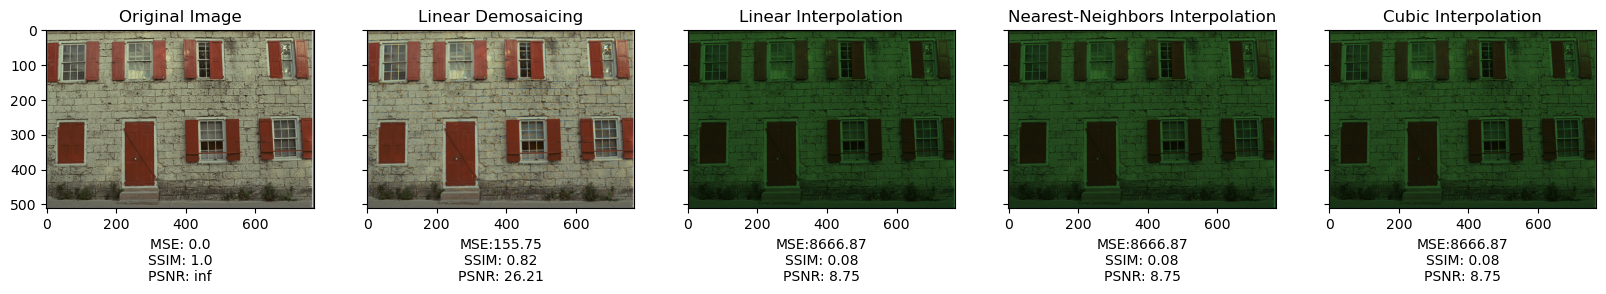

In [9]:
bayer_pattern(image_list[0])